<a href="https://colab.research.google.com/github/macbhaldar/Data-Science-Projects/blob/main/Wallmart-Sales-Prediction/Walmart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Importing the basic librarires
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [12]:
#Importing the dataset

df = pd.read_csv('Walmart.csv')

#df.drop(['car name'], axis=1, inplace=True)
display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Inference: The Datset consists of 8 features & 6435 samples.


In [13]:
# Reframing the columns
df.Date=pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

df.drop(['Date'], axis=1, inplace=True)#,'month'

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [14]:
# Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [15]:
# Checking number of unique rows in each feature
df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [16]:
# Checking number of unique rows in each feature
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [17]:
# Checking the stats of all the columns
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


## Exploratory Data Analysis (EDA)

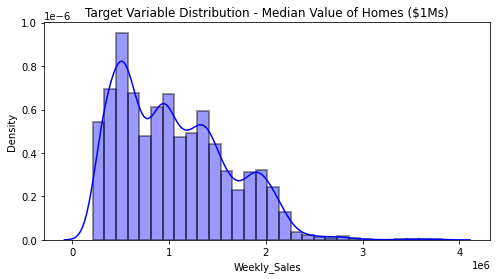

In [19]:
# Analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


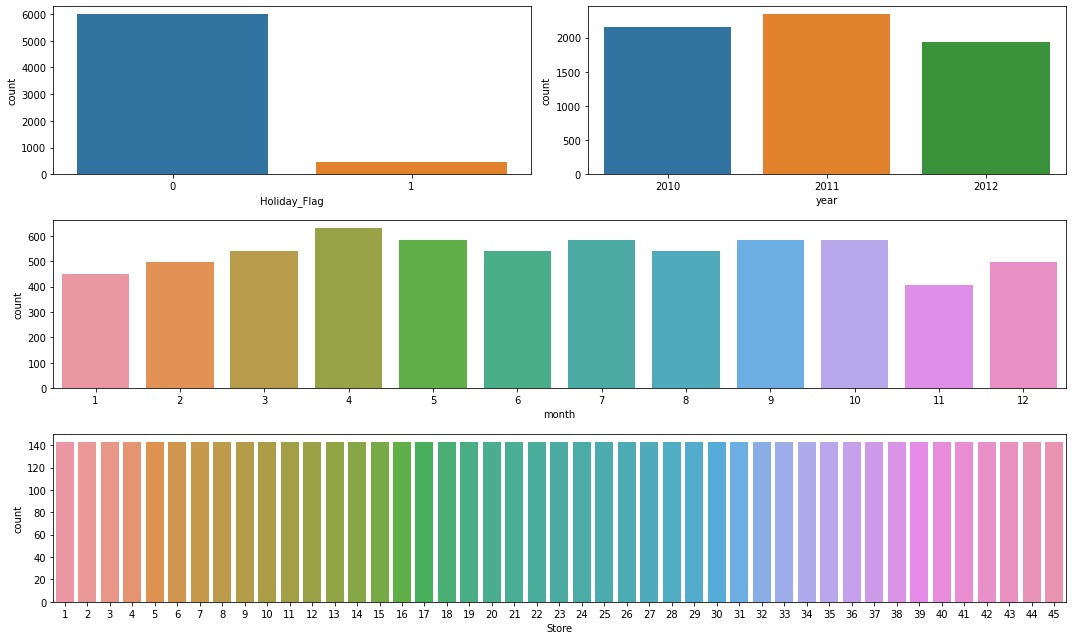

In [20]:
# Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                                Numeric Features Distribution                                                 


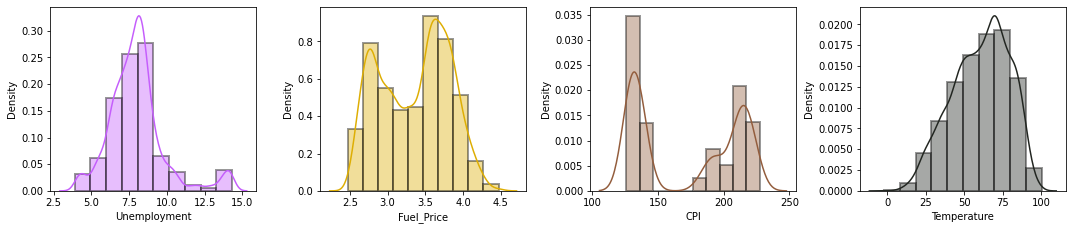

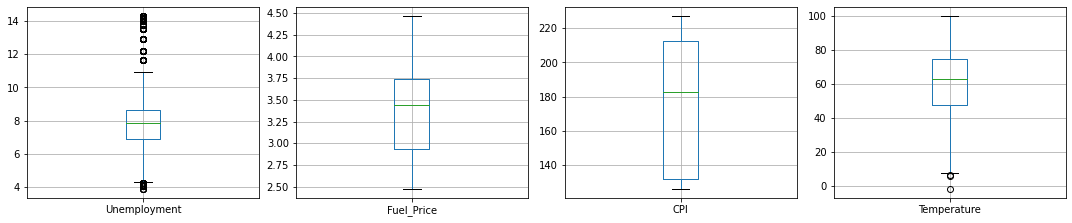

In [21]:
# Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

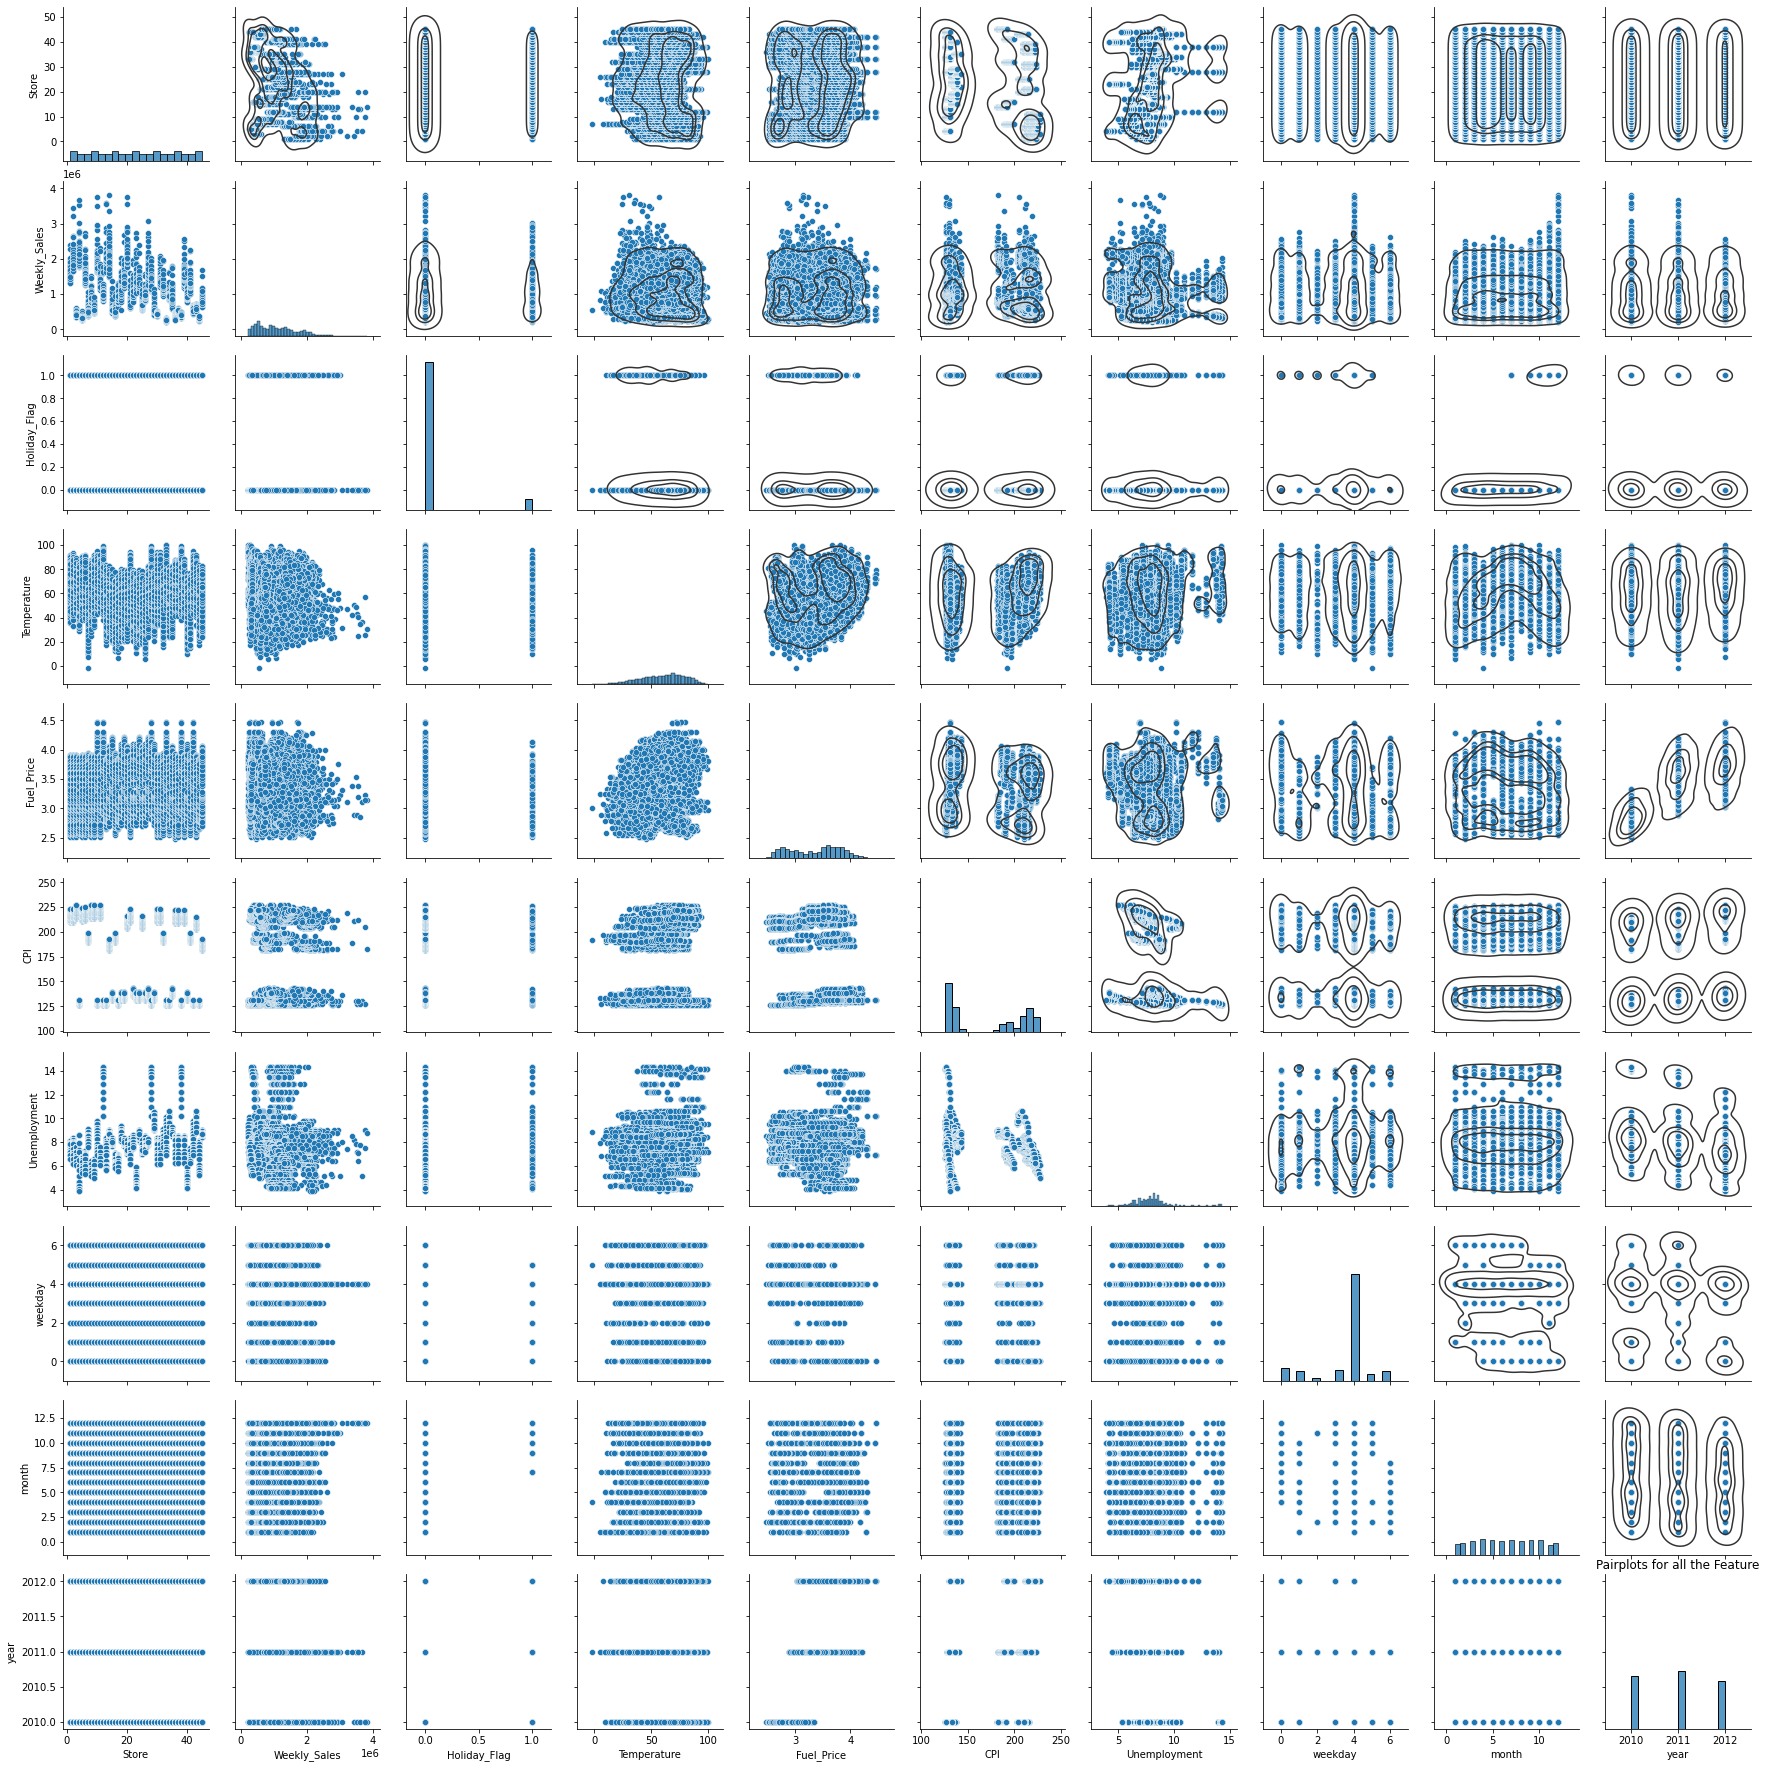

In [22]:
# Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

## Data Preprocessing

In [23]:
# Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [24]:
# Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


In [25]:
# Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store


(6435, 69)

In [26]:
# Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


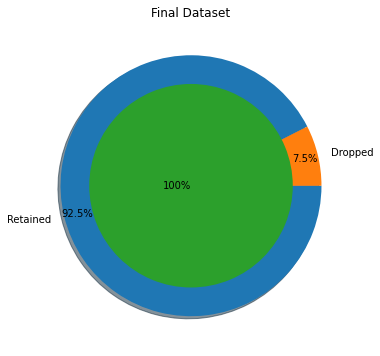


Inference: After the cleanup process, 482 samples were dropped, while retaining 7.49% of the data.


In [27]:
# Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

## Data Manipulation

In [28]:
# Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


In [29]:
# Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.741339e-16,-1.494674e-16,-3.367039e-16,-2.799804e-16,-4.039888e-16,3.964583e-16,3.839385e-16,-3.934507e-16,1.890317e-16,3.962484e-16,...,-4.515031e-16,-6.241216e-16,-1.086772e-15,-6.947287e-16,-2.611192e-17,3.944649e-16,-1.004738e-15,5.259687e-16,6.589880e-16,6.687683e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
25%,-2.742012e-01,-7.314248e-01,-9.886990e-01,-1.076949e+00,-6.783836e-01,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
50%,-2.742012e-01,1.062547e-01,1.663112e-01,3.842133e-01,9.596435e-02,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
75%,-2.742012e-01,7.731979e-01,8.427860e-01,9.933828e-01,6.138095e-01,1.328679e+00,1.569482e+00,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
max,3.646958e+00,2.170008e+00,2.469806e+00,1.340791e+00,2.575491e+00,1.328679e+00,1.569482e+00,3.863473e+00,8.636394e+00,3.676723e+00,...,6.356783e+00,6.300861e+00,2.298067e+01,6.328643e+00,7.650163e+00,6.503146e+00,6.356783e+00,6.141290e+00,6.443435e+00,6.564495e+00



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.052984,0.065042,0.007679,0.038532,0.026409,...,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,1.014188,1.028250,1.014142,1.152364,1.044095,...,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
50%,-0.274201,0.187351,0.298996,0.393492,0.058860,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
75%,-0.274201,0.818764,0.844961,1.019967,0.611390,1.328679,1.569482,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
max,3.646958,2.035481,2.469806,1.345814,2.575491,1.328679,1.569482,3.863473,8.636394,3.676723,...,6.356783,6.300861,22.980668,6.328643,7.650163,6.503146,6.356783,6.141290,6.443435,6.564495


## Feature Selection/Extraction

                                       Correlation Matrix                                       


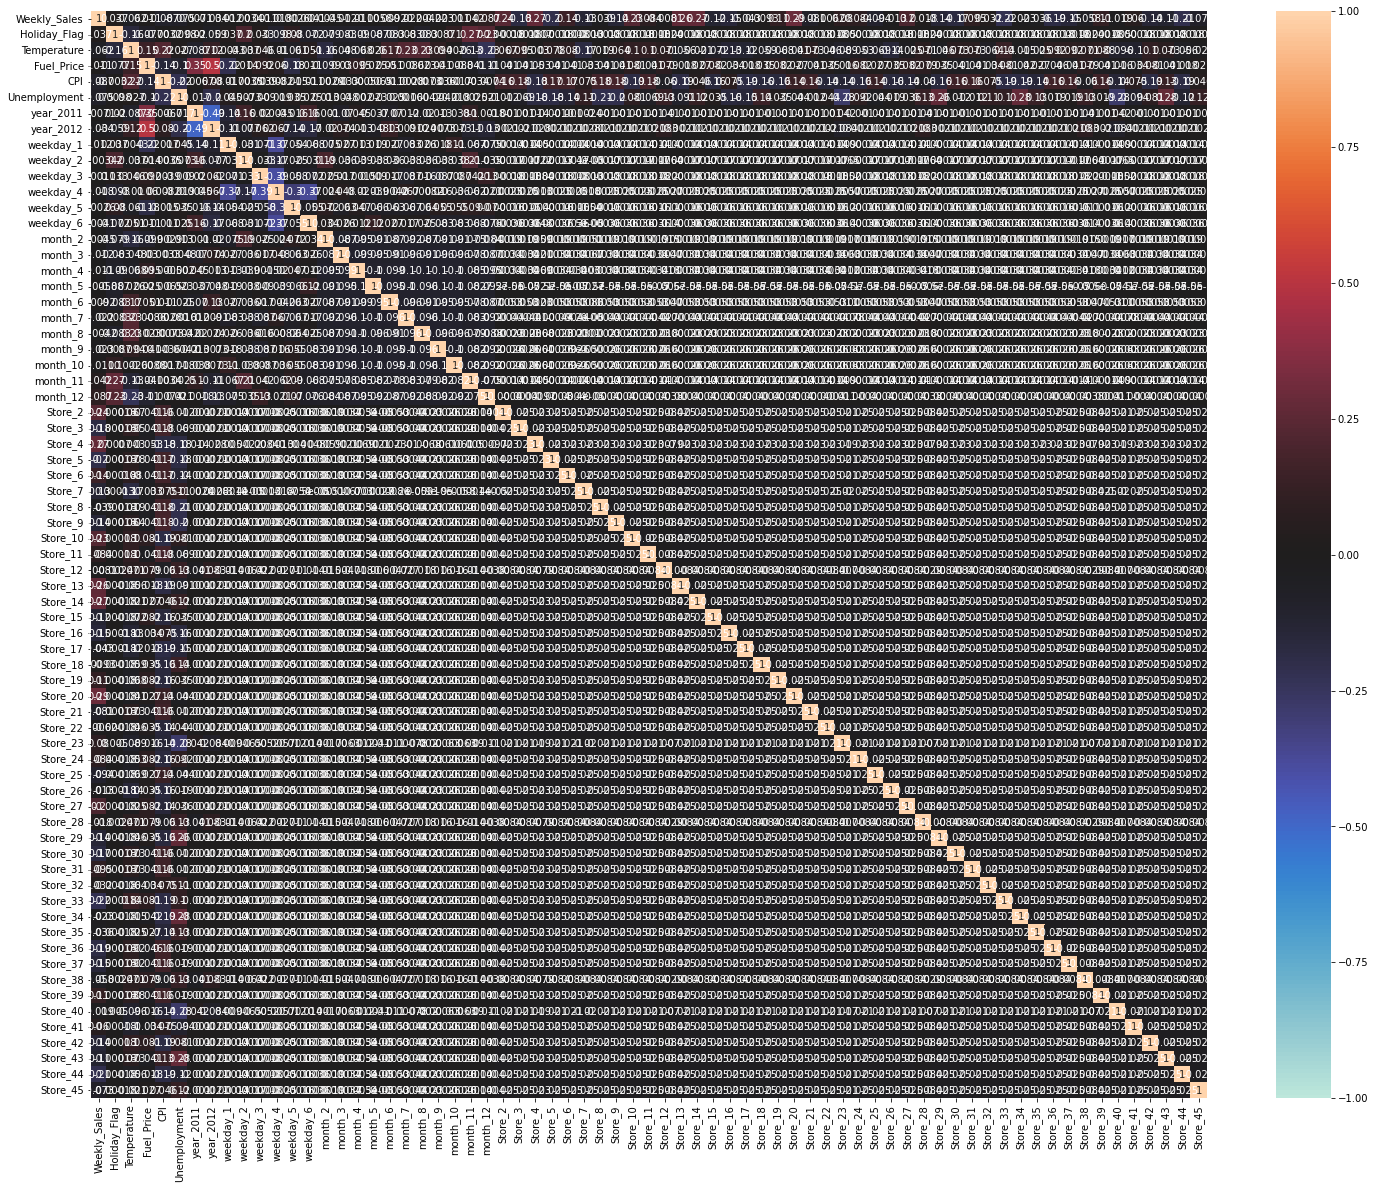

In [30]:
# Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [31]:
# Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     958.4
Date:                Sun, 20 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:38:18   Log-Likelihood:                -63430.
No. Observations:                4762   AIC:                         1.270e+05
Df Residuals:                    4693   BIC:                         1.274e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.048e+06   2152.234    486.752      0.000    1.04e+06    1.05e+06
Holiday_Flag  3435.7934   2436.850      1.410      0.159   -1341.577    8213.164
Temperature  -1.091e+04   3611.329     -3.022      0.003    -1.8e+04   -3834.746
Fuel_Price    4743.1404   6083.604      0.780      0.436   -7183.581    1.67e+04
CPI           4.806e+05   6.53e+04      7.359      0.000    3.53e+05    6.09e+05
Unemployment -6.096e+04   7305.771     -8.344      0.000   -7.53e+04   -4.66e+04
year_2011    -3.085e+04   6385.220     -4.832      0.000   -4.34e+04   -1.83e+04
year_2012    -7.005e+04   8794.662     -7.965      0.000   -8.73e+04   -5.28e+04
weekday_1     5298.1880   3028.935      1.749      0.080    -639.948    1.12e+04
weekday_2    -1.144e+04   2552.678     -4.481      0.000   -1.64e+04   -6435.135
weekday_3    -1.397e+04   3035.015     -4.603      0.000   -1.99e+04   -8021.037
weekday_4    -1.668e+04   4056.274     -4.113      0.000   -2.46e+04   -8730.185
weekday_5    -1.288e+04   2827.562     -4.555      0.000   -1.84e+04   -7335.388
weekday_6    -2292.8321   3074.313     -0.746      0.456   -8319.930    3734.265
month_2       2.869e+04   3169.875      9.050      0.000    2.25e+04    3.49e+04
month_3       2.018e+04   3233.395      6.243      0.000    1.38e+04    2.65e+04
month_4       2.099e+04   3462.153      6.062      0.000    1.42e+04    2.78e+04
month_5       2.214e+04   3478.401      6.364      0.000    1.53e+04     2.9e+04
month_6       3.159e+04   3270.641      9.659      0.000    2.52e+04     3.8e+04
month_7       1.905e+04   3478.984      5.474      0.000    1.22e+04    2.59e+04
month_8       2.445e+04   3357.585      7.282      0.000    1.79e+04     3.1e+04
month_9       1.231e+04   3456.199      3.561      0.000    5531.812    1.91e+04
month_10      1.696e+04   3519.751      4.820      0.000    1.01e+04    2.39e+04
month_11      4.132e+04   3243.964     12.736      0.000     3.5e+04    4.77e+04
month_12      6.241e+04   3556.769     17.546      0.000    5.54e+04    6.94e+04
Store_2       5.522e+04   2977.883     18.545      0.000    4.94e+04    6.11e+04
Store_3      -1.841e+05   3122.600    -58.973      0.000    -1.9e+05   -1.78e+05
Store_4       2.173e+05   2.14e+04     10.161      0.000    1.75e+05    2.59e+05
Store_5      -1.914e+05   3140.260    -60.961      0.000   -1.98e+05   -1.85e+05
Store_6      -9300.0797   3167.398     -2.936      0.003   -1.55e+04   -3090.492
Store_7      -1.058e+05   6373.008    -16.605      0.000   -1.18e+05   -9.33e+04
Store_8       -1.21e+05   3457.789    -34.980      0.000   -1.28e+05   -1.14e+05
Store_9      -1.635e+05   3269.593    -50.014      0.000    -1.7e+05   -1.57e+05
Store_10       2.18e+05   2.21e+04      9.844      0.000    1.75e+05    2.61e+05
Store_11     -4.043e+04   3138.072    -12.885      0.000   -4.66e+04   -3.43e+04
Store

## Manual Method - VIF

Dropped Features -->  ['CPI', 'Unemployment', 'Fuel_Price', 'weekday_4', 'month_7', 'Store_7', 'Temperature', 'month_12', 'Store_43', 'year_2012', 'Store_30', 'month_2', 'month_11', 'Store_16', 'month_5', 'Store_25', 'Store_29', 'month_10', 'Store_17', 'Holiday_Flag', 'Store_18', 'year_2011', 'Store_19', 'month_9', 'Store_20', 'Store_8', 'Store_34', 'Store_15', 'Store_22', 'month_6', 'Store_21', 'Store_35', 'Store_14', 'Store_13', 'Store_45', 'Store_27', 'month_3', 'weekday_1', 'Store_23', 'Store_44', 'Store_42', 'Store_11', 'weekday_5', 'Store_39', 'weekday_2', 'weekday_3', 'Store_24', 'Store_41', 'Store_40', 'Store_10', 'Store_36', 'Store_9', 'month_4', 'Store_2', 'Store_3', 'Store_6']


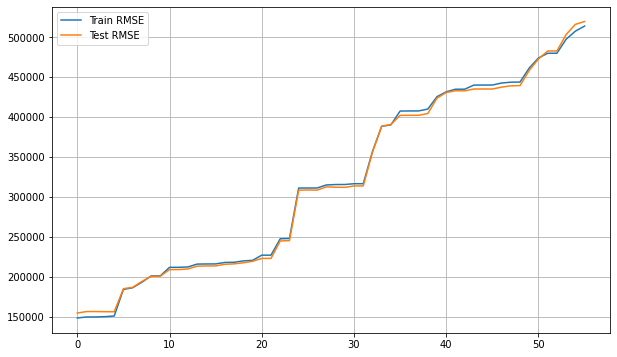

In [32]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]
for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

## Automatic Method - RFE

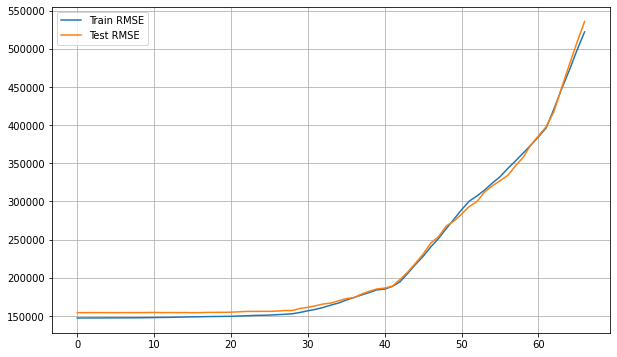

In [33]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

## Feature Elmination using PCA Decomposition

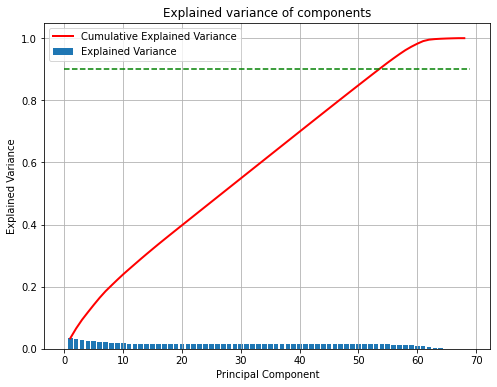

In [34]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

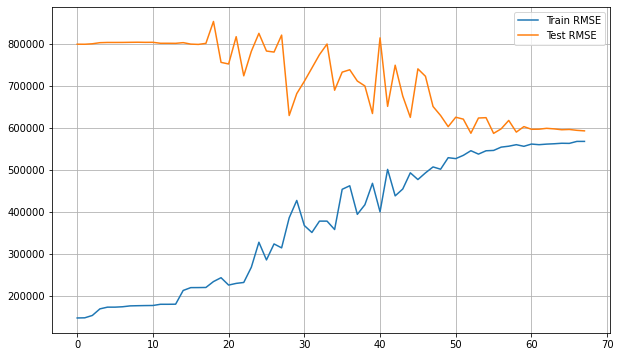

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)
    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

In [36]:
#Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-28)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

152984.3455868294
157283.79051514965


## Predictive Modelling

In [38]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
     
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test') 

    plt.ylabel('y_pred')                       
    plt.show()

## Multiple Linear Regression(MLR)

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


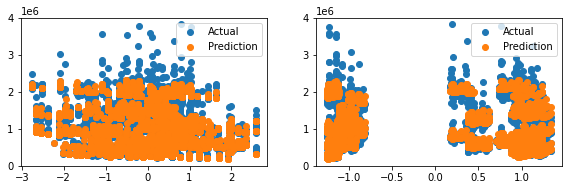



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9276826744775732
Residual Sum of Squares (RSS) on Training set  ---> 111450847994430.22
Mean Squared Error (MSE) on Training set       ---> 23404209994.630455
Root Mean Squared Error (RMSE) on Training set ---> 152984.3455868294

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.927676279121959
Residual Sum of Squares (RSS) on Training set  ---> 29463185193746.86
Mean Squared Error (MSE) on Training set       ---> 24738190758.813484
Root Mean Squared Error (RMSE) on Training set ---> 157283.79051514965

--------------------Residual Plots--------------------


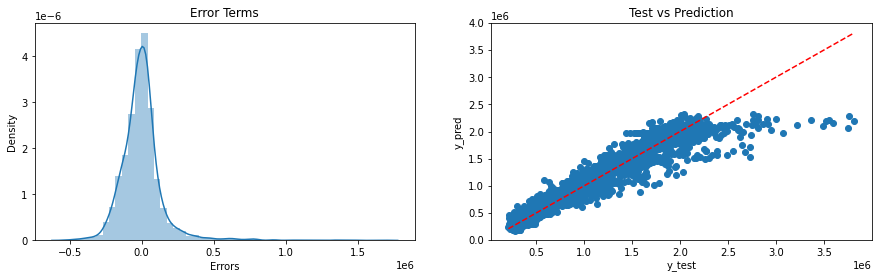

In [39]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

### Ridge Regression Model

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


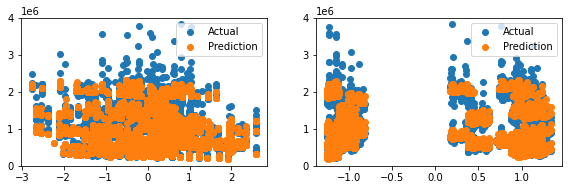



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9276821973327432
Residual Sum of Squares (RSS) on Training set  ---> 111451583339598.72
Mean Squared Error (MSE) on Training set       ---> 23404364414.02745
Root Mean Squared Error (RMSE) on Training set ---> 152984.85027618732

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.927696636618113
Residual Sum of Squares (RSS) on Training set  ---> 29454891971661.734
Mean Squared Error (MSE) on Training set       ---> 24731227516.08878
Root Mean Squared Error (RMSE) on Training set ---> 157261.65303750554

--------------------Residual Plots--------------------


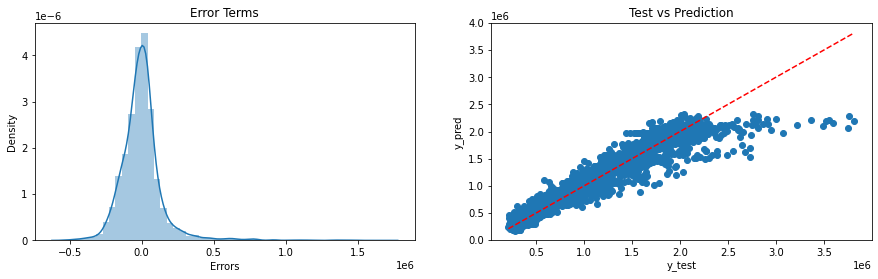

In [40]:
# Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

### Lasso Regression Model

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


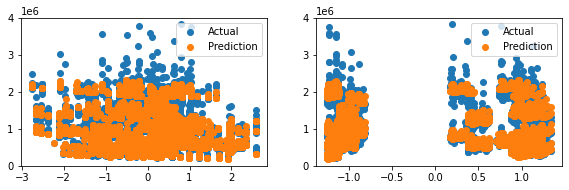



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9276826740433101
Residual Sum of Squares (RSS) on Training set  ---> 111450848663688.89
Mean Squared Error (MSE) on Training set       ---> 23404210135.171963
Root Mean Squared Error (RMSE) on Training set ---> 152984.3460461624

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9276767498337136
Residual Sum of Squares (RSS) on Training set  ---> 29462993435532.15
Mean Squared Error (MSE) on Training set       ---> 24738029752.75579
Root Mean Squared Error (RMSE) on Training set ---> 157283.27868135186

--------------------Residual Plots--------------------


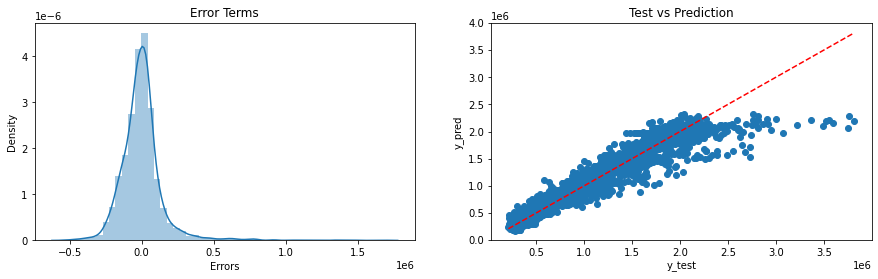

In [41]:
# Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

### Elastic-Net Regression

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


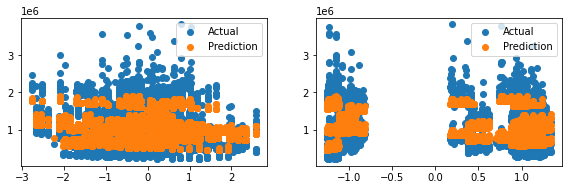



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.7477826893125253
Residual Sum of Squares (RSS) on Training set  ---> 388701226876489.0
Mean Squared Error (MSE) on Training set       ---> 81625625131.56006
Root Mean Squared Error (RMSE) on Training set ---> 285701.9865726524

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.7599512663907991
Residual Sum of Squares (RSS) on Training set  ---> 97790879783118.03
Mean Squared Error (MSE) on Training set       ---> 82108211404.80104
Root Mean Squared Error (RMSE) on Training set ---> 286545.3042797963

--------------------Residual Plots--------------------


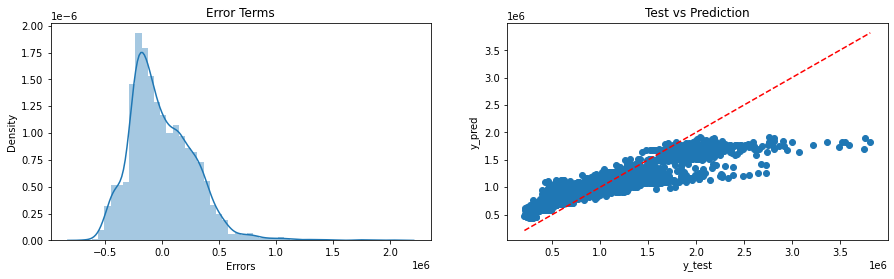

In [42]:
# ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

### Polynomial Regression Model

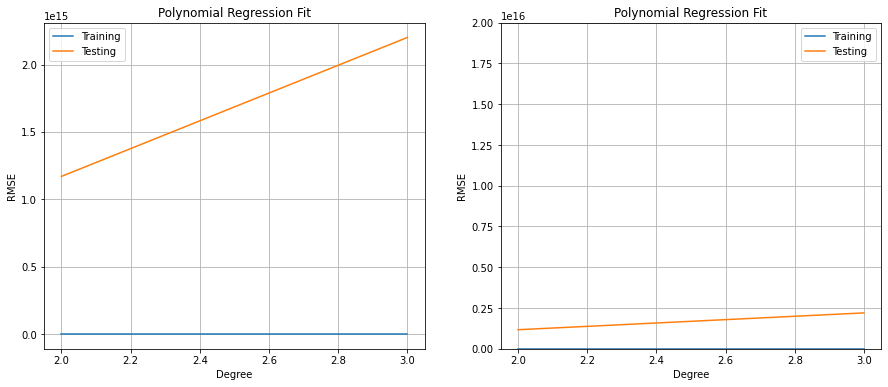

In [43]:
# Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 382416.72707697  -87749.08819447  -33466.21811552  -70608.43596712
   23371.88280837   44272.12738693   67885.30758384 -171730.97447116
  194110.33061399 -182942.03065485  -95260.47050719 -110787.17299967
 -154257.07523525  200572.26744363  -27802.83358985   36027.35653929
  202356.39957846  137960.5727378  -126652.1156391    29819.45548371
   75864.89398192  119328.98106792  104372.22301835 -108321.57336704
   54083.53671998   65645.06638736  110781.93941655 -114111.68634244
   52174.80531825  169276.22877422   47325.81863416 -164944.63849199
  -45218.40228284   78308.2717848    42369.70043942 -163871.15661923
 -143446.53544316  -94113.42272716  -57253.08807135  -49965.33157002]
The Intercept of the Regresion Model was found to be  1047603.298112138


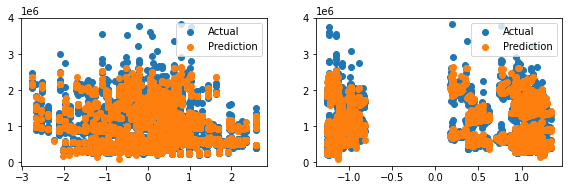



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9432419738785847
Residual Sum of Squares (RSS) on Training set  ---> 87471848495835.88
Mean Squared Error (MSE) on Training set       ---> 18368720809.70934
Root Mean Squared Error (RMSE) on Training set ---> 135531.25399593016

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -4.002537239438746e+18
Residual Sum of Squares (RSS) on Training set  ---> 1.6305507307804646e+33
Mean Squared Error (MSE) on Training set       ---> 1.369060227355554e+30
Root Mean Squared Error (RMSE) on Training set ---> 1170068471225318.5

--------------------Residual Plots--------------------


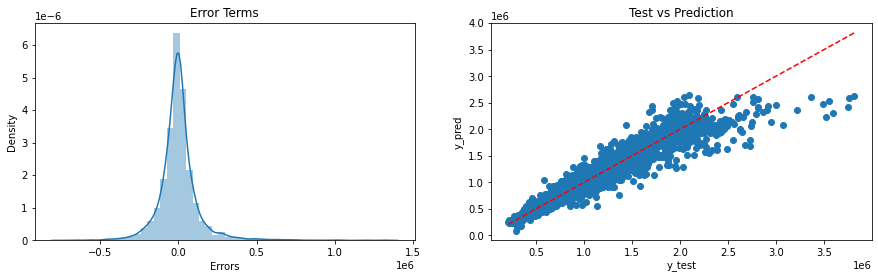

In [44]:
# Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

### Comparing the Evaluation Metics of the Models

In [45]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.927683,9.276763e-01,1.114508e+14,2.946319e+13,2.340421e+10,2.473819e+10,152984.345587,1.572838e+05
Ridge Linear Regression (RLR),0.927682,9.276966e-01,1.114516e+14,2.945489e+13,2.340436e+10,2.473123e+10,152984.850276,1.572617e+05
Lasso Linear Regression (LLR),0.927683,9.276767e-01,1.114508e+14,2.946299e+13,2.340421e+10,2.473803e+10,152984.346046,1.572833e+05
Elastic-Net Regression (ENR),0.747783,7.599513e-01,3.887012e+14,9.779088e+13,8.162563e+10,8.210821e+10,285701.986573,2.865453e+05
Polynomial Regression (PNR),0.943242,-4.002537e+18,8.747185e+13,1.630551e+33,1.836872e+10,1.369060e+30,135531.253996,1.170068e+15


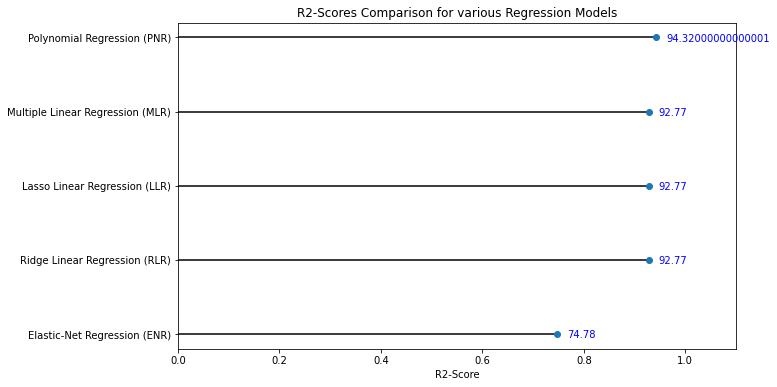

In [46]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

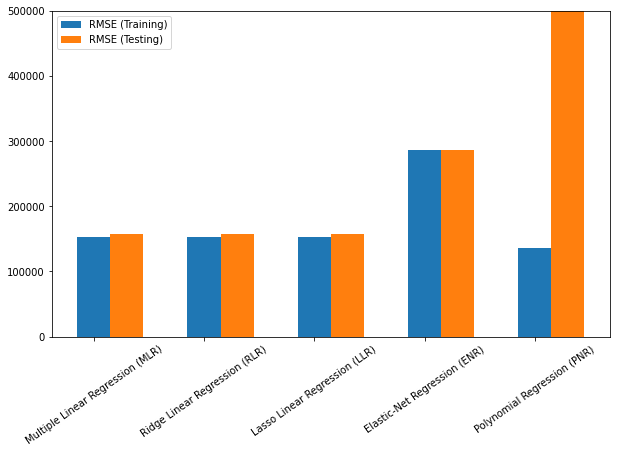

In [47]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,500000])
plt.show()

## Outcomes & Conclusions
- The Dataset was quiet small with just 6435 samples & after preprocessing 7.5% of the datasamples were dropped.
- Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.
- The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
- It is safe to use multiple regression algorithm performed better than other algorithms, as their scores were quiet comparable & also they're more generalisable.